按照pct_change來進行測算，測算未來 N 天的變化趨勢。

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from LSTM_for_Stock.data_processor import DataLoader
from LSTM_for_Stock.data_processor import FeaturesAppender
from LSTM_for_Stock.model import Model
from LSTM_for_Stock import unit
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns  

import traceback

Using TensorFlow backend.


In [19]:
def plot_result_by_pct_change(X,Y, window, top=100,figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(X, color='b')
    sort_Y=[]
    for y in Y:
        sort_Y.append(y[-1]-y[0])
    for i, data in enumerate(Y):
        try:
            if top > 0 and (data[-1] - data[0] not in sorted(sort_Y)[:top] and
                            data[-1] - data[0] not in sorted(sort_Y)[-top:]):
                continue
            # 绘制预测值从开始点到结束点的直线
            for j,y in enumerate(data):
                s=X[i + window] if j==0 else data[j-1]
                e=y
                plt.plot([i + window, i + window + j], [s, e],
                     color=('r' if e > s else 'g'))
            # 绘制预测值从开始点到结束点的直线
        except Exception:
            continue
    return plt

def do(code, benchmark='399300', train_epochs=10, window=10, days=3, norm=True, split=0.15, features_appender=None, top=30,figsize=(15, 5)):
    dataloader = DataLoader(code, benchmark,
                            features_appender=features_appender)
    print(dataloader.data.head())
    model = Model()
    comp = {"optimizer": "adam",
            "loss": "mse",
            "metrics": [
                "mae",
                "acc"
            ]}
    layers = [
        {'units': 500, 'type': 'lstm'},
        {'units': days, 'type': 'dense'}
    ]
    train = {'epochs': train_epochs, 'verbose': 2,
             'validation_split': split, 'batch_size': 128}

    model.build_model(layers, comp)
    X_tra, Y_tra = dataloader.get_train_data(window, days, norm)
    X_tra_round = np.round(X_tra, 4)
    print(pd.DataFrame(X_tra_round[:1,0][0]))
    Y_tra_round = Y_tra
    history = model.train(X_tra_round, Y_tra_round, train)
    unit.plot_history(history)

    X_val, Y_val = dataloader.get_valid_data(window, days, norm)
    X_val_round = np.round(X_val, 4)
    score = None
    Y_val_round = Y_val
    score = model.evaluate(X_val_round, Y_val_round, {'batch_size': 128})

    for i in range(len(model.model.metrics_names)):
        print('{0}:{1}'.format(model.model.metrics_names[i], score[i]))

    try:
        pred_slope = model.predict(X_val_round, {'batch_size': 128})
        start_online=dataloader._df_valid.index[0].strftime('%Y-%m-%d')
        data_online = DataLoader(code, benchmark, split=0, start=start_online, online=True, features_appender=features_appender)
        print(data_online.data.head())
        X_online = data_online.get_train_data(window, days, norm)[0][:, 0, 0]
        # 验证集误差计算
        plot_result_by_pct_change(X_online, pred_slope, window,top=top, figsize=figsize).show()
#         d=DataLoader(code, benchmark, split=0, start=start_online, online=True).data
        
#         plt.figure(figsize=figsize)
#         sns.lineplot(data=d['close'])
    except Exception as e:
        print(e)
        traceback.print_exc()

In [3]:
import QUANTAXIS as QA
import talib

def talib_TRANGE(DataFrame):
    res = talib.TRANGE(DataFrame.high.values,DataFrame.low.values,DataFrame.close.values)
    return pd.DataFrame({'TRANGE': res}, index=DataFrame.index)
def talib_OBV(DataFrame):
    res = talib.OBV(DataFrame.close.values, DataFrame.volume.values)
    return pd.DataFrame({'OBV': res}, index=DataFrame.index)
def talib_AVGPRICE(DataFrame):
    res = talib.AVGPRICE(DataFrame.open.values,DataFrame.high.values,DataFrame.low.values,DataFrame.close.values)
    return pd.DataFrame({'AVGPRICE': res}, index=DataFrame.index)
def talib_MEDPRICE(DataFrame):
    res = talib.MEDPRICE(DataFrame.high.values,DataFrame.low.values)
    return pd.DataFrame({'MEDPRICE': res}, index=DataFrame.index)
def talib_TYPPRICE(DataFrame):
    res = talib.TYPPRICE(DataFrame.high.values,DataFrame.low.values,DataFrame.close.values)
    return pd.DataFrame({'TYPPRICE': res}, index=DataFrame.index)
def talib_WCLPRICE(DataFrame):
    res = talib.WCLPRICE(DataFrame.high.values,DataFrame.low.values,DataFrame.close.values)
    return pd.DataFrame({'WCLPRICE': res}, index=DataFrame.index)
def talib_NATR(DataFrame,N=14):
    res = talib.NATR(DataFrame.high.values,DataFrame.low.values,DataFrame.close.values,timeperiod=N)
    return pd.DataFrame({'NATR': res}, index=DataFrame.index)
def talib_DEMA(DataFrame,N=30):
    res = talib.DEMA(DataFrame.close.values,timeperiod=N)
    return pd.DataFrame({'DEMA': res}, index=DataFrame.index)
def talib_HT_TRENDLINE(DataFrame):
    res = talib.HT_TRENDLINE(DataFrame.close.values)
    return pd.DataFrame({'HT_TRENDLINE': res}, index=DataFrame.index)
def talib_KAMA(DataFrame,N=30):
    res = talib.KAMA(DataFrame.close.values,timeperiod=N)
    return pd.DataFrame({'KAMA': res}, index=DataFrame.index)
def talib_MIDPOINT(DataFrame, N=14):
    res = talib.MIDPOINT(DataFrame.close.values, timeperiod=N)
    return pd.DataFrame({'MIDPOINT': res}, index=DataFrame.index)
def talib_MIDPRICE(DataFrame, N=14):
    res = talib.MIDPRICE(DataFrame.high.values, DataFrame.low.values, timeperiod=N)
    return pd.DataFrame({'MIDPRICE': res}, index=DataFrame.index)
def talib_T3(DataFrame, N=5, vfactor=0):
    res = talib.T3(DataFrame.close.values, timeperiod=N,vfactor=vfactor)
    return pd.DataFrame({'T3': res}, index=DataFrame.index)
def talib_TEMA(DataFrame, N=30):
    res = talib.TEMA(DataFrame.close.values, timeperiod=N)
    return pd.DataFrame({'TEMA': res}, index=DataFrame.index)
def talib_TRIMA(DataFrame, N=30):
    res = talib.TRIMA(DataFrame.close.values, timeperiod=N)
    return pd.DataFrame({'TRIMA': res}, index=DataFrame.index)
def talib_WMA(DataFrame, N=30):
    res = talib.WMA(DataFrame.close.values, timeperiod=N)
    return pd.DataFrame({'WMA': res}, index=DataFrame.index)
class features_appender(FeaturesAppender):
    def appendFeautres(self, df) -> (pd.DataFrame, [str]):
        df=df.fillna(method='ffill').dropna()
        cols=df.columns
        new_cols=[]
        for col in cols:
            df[col+'_pct']=df[col].pct_change()
            new_cols.append(col+'_pct')
#         df['PCT_CHANGE_CLOSE']=df['close'].pct_change()
#         df['AD']=QA.talib_indicators.AD(df)
#         adosc=self.kwargs['ADOSC'] if 'ADOSC' in self.kwargs else 5
#         df['ADOSC_1']=QA.talib_indicators.ADOSC(df,adosc,adosc*2)
#         df['ADOSC_2']=QA.talib_indicators.ADOSC(df,(int)(adosc/2),adosc)
#         df['OBV']=talib_OBV(df)
        
# #         df["dayofweek"] = df.index.dayofweek
# #         df["dayofyear"] = df.index.dayofyear
# #         df["daysinmonth"] = df.index.daysinmonth
        
#         df['AVGPRICE']=talib_AVGPRICE(df)
#         df['MEDPRICE']=talib_MEDPRICE(df)
#         df['TYPPRICE']=talib_TYPPRICE(df)
#         df['WCLPRICE']=talib_WCLPRICE(df)
        
#         df['ATR']=QA.talib_indicators.ATR(df,self.kwargs['ATR'] if 'ATR' in self.kwargs else 14)
#         df['NATR']=talib_NATR(df,self.kwargs['NATR'] if 'NATR' in self.kwargs else 14)
#         df['TRANGE']=talib_TRANGE(df)
#         df['DEMA']=talib_DEMA(df,self.kwargs['DEMA'] if 'DEMA' in self.kwargs else 30)
#         df['EMA']=QA.QA_indicator_EMA(df,self.kwargs['EMA'] if 'EMA' in self.kwargs else 30)
#         df['HT_TRENDLINE']=talib_HT_TRENDLINE(df)
#         df['KAMA']=talib_KAMA(df,self.kwargs['KAMA'] if 'KAMA' in self.kwargs else 30)
#         df['MIDPOINT']=talib_MIDPOINT(df,self.kwargs['MIDPOINT'] if 'MIDPOINT' in self.kwargs else 30)
#         df['MIDPRICE']=talib_MIDPRICE(df,self.kwargs['MIDPRICE'] if 'MIDPRICE' in self.kwargs else 30)
#         df['SAR']=QA.talib_indicators.SAR(df)
#         df['SAREXT']=QA.talib_indicators.SAREXT(df)
#         df['SMA']=QA.QA_indicator_SMA(df,self.kwargs['SMA'] if 'SMA' in self.kwargs else 30)
#         df['T3']=talib_T3(df,self.kwargs['T3'] if 'T3' in self.kwargs else 30)
#         df['TEMA']=talib_TEMA(df,self.kwargs['TEMA'] if 'TEMA' in self.kwargs else 30)
#         df['TRIMA']=talib_TRIMA(df,self.kwargs['TRIMA'] if 'TRIMA' in self.kwargs else 30)
#         df['WMA']=talib_WMA(df,self.kwargs['WMA'] if 'WMA' in self.kwargs else 30)
        df=df.drop(columns=cols)
        df=df.dropna()
#         return df,["dayofweek","dayofyear","daysinmonth",'TRANGE','ATR']#無需再做Norm的列
        return df,new_cols#無需再做Norm的列

In [4]:
kwargs={"ADOSC":10,"ATR":10,"NATR":10,"DEMA":10,"EMA":10,"KAMA":10,"MIDPOINT":10,"MIDPRICE":10,"SMA":10,"T3":10,"TEMA":10,"TRIMA":10,"WMA":10}
fa=features_appender(kwargs)

In [5]:
# do('601398',train_epochs=10,  window=10, days=1,use_slope=False,features_appender=features_appender_10_2_2(),top=150)

#### 未來2日

            close_pct  open_pct  high_pct   low_pct  volume_pct  \
date                                                              
2006-10-30   0.003049 -0.038235 -0.034884 -0.003067   -0.863731   
2006-10-31   0.003040  0.003058  0.003012  0.009231   -0.346086   
2006-11-01   0.000000  0.006098 -0.006006  0.000000   -0.422524   
2006-11-02  -0.006061  0.000000 -0.003021 -0.009146    0.318024   
2006-11-03   0.024390 -0.009091  0.021212  0.006154    1.283778   

            close_benchmark_pct  open_benchmark_pct  high_benchmark_pct  \
date                                                                      
2006-10-30             0.004996           -0.013269           -0.009730   
2006-10-31             0.012605            0.007239            0.012612   
2006-11-01             0.010202            0.012861            0.010195   
2006-11-02             0.000169            0.010152            0.000771   
2006-11-03             0.005832            0.000696            0.011428   

    

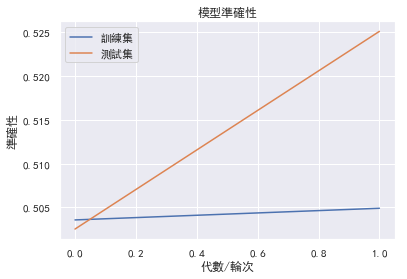

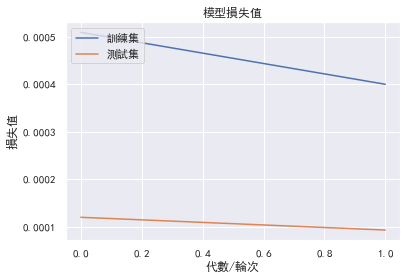

284/284 [==============================] - ETA:  - 0s 370us/step
loss:0.0002464205085551596
mean_absolute_error:0.011251459219558557
acc:0.528169012825254
            close_pct  open_pct  high_pct   low_pct  volume_pct  \
date                                                              
2017-11-07   0.003306 -0.004950  0.003289  0.000000    1.143128   
2017-11-08  -0.004942  0.004975 -0.001639  0.000000   -0.091911   
2017-11-09  -0.016556 -0.006601 -0.009852 -0.010000   -0.126440   
2017-11-10  -0.020202 -0.011628 -0.013267 -0.021886    0.541767   
2017-11-13   0.024055 -0.018487  0.005042  0.003442   -0.028405   

            close_benchmark_pct  open_benchmark_pct  high_benchmark_pct  \
date                                                                      
2017-11-07             0.008297            0.008328            0.010588   
2017-11-08            -0.001539            0.007232            0.006134   
2017-11-09             0.006890           -0.002078           -0.003067   


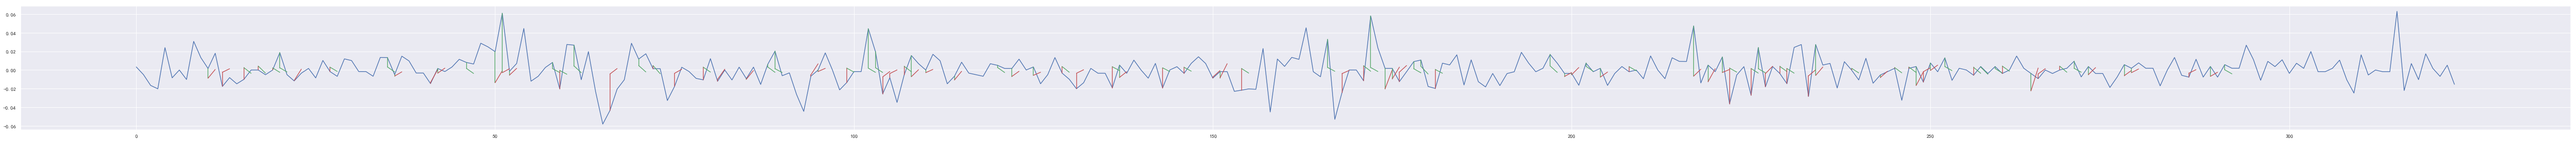

In [20]:
do('601398',train_epochs=2,  window=10, days=2,norm=False,features_appender=fa,top=50,figsize=(100, 5))

            close_pct  open_pct  high_pct   low_pct  volume_pct  \
date                                                              
2006-10-30   0.003049 -0.038235 -0.034884 -0.003067   -0.863731   
2006-10-31   0.003040  0.003058  0.003012  0.009231   -0.346086   
2006-11-01   0.000000  0.006098 -0.006006  0.000000   -0.422524   
2006-11-02  -0.006061  0.000000 -0.003021 -0.009146    0.318024   
2006-11-03   0.024390 -0.009091  0.021212  0.006154    1.283778   

            close_benchmark_pct  open_benchmark_pct  high_benchmark_pct  \
date                                                                      
2006-10-30             0.004996           -0.013269           -0.009730   
2006-10-31             0.012605            0.007239            0.012612   
2006-11-01             0.010202            0.012861            0.010195   
2006-11-02             0.000169            0.010152            0.000771   
2006-11-03             0.005832            0.000696            0.011428   

    

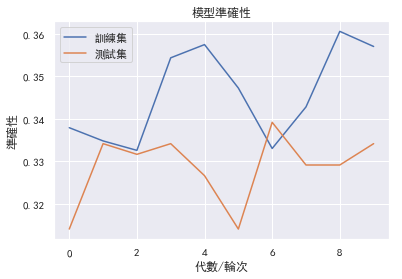

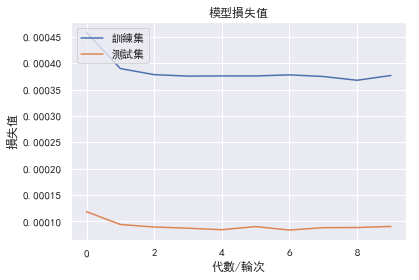

283/283 [==============================] - ETA:  - ETA:  - 0s 410us/step
loss:0.00024650854655757854
mean_absolute_error:0.011376024544726096
acc:0.3745583034656916
            close_pct  open_pct  high_pct   low_pct  volume_pct  \
date                                                              
2017-11-07   0.003306 -0.004950  0.003289  0.000000    1.143128   
2017-11-08  -0.004942  0.004975 -0.001639  0.000000   -0.091911   
2017-11-09  -0.016556 -0.006601 -0.009852 -0.010000   -0.126440   
2017-11-10  -0.020202 -0.011628 -0.013267 -0.021886    0.541767   
2017-11-13   0.024055 -0.018487  0.005042  0.003442   -0.028405   

            close_benchmark_pct  open_benchmark_pct  high_benchmark_pct  \
date                                                                      
2017-11-07             0.008297            0.008328            0.010588   
2017-11-08            -0.001539            0.007232            0.006134   
2017-11-09             0.006890           -0.002078           -0.

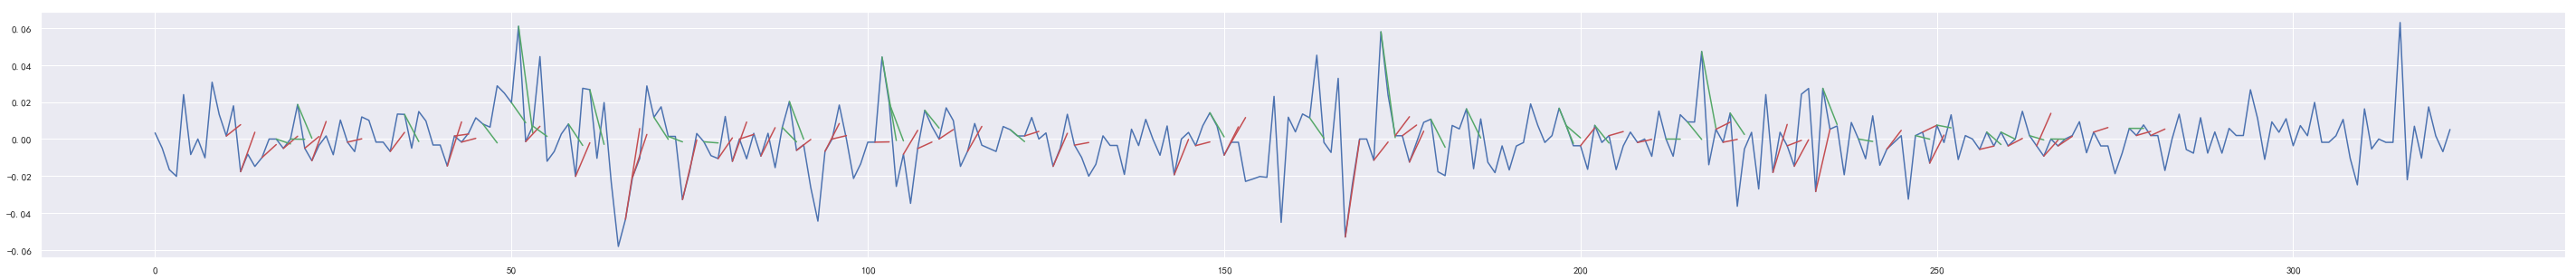

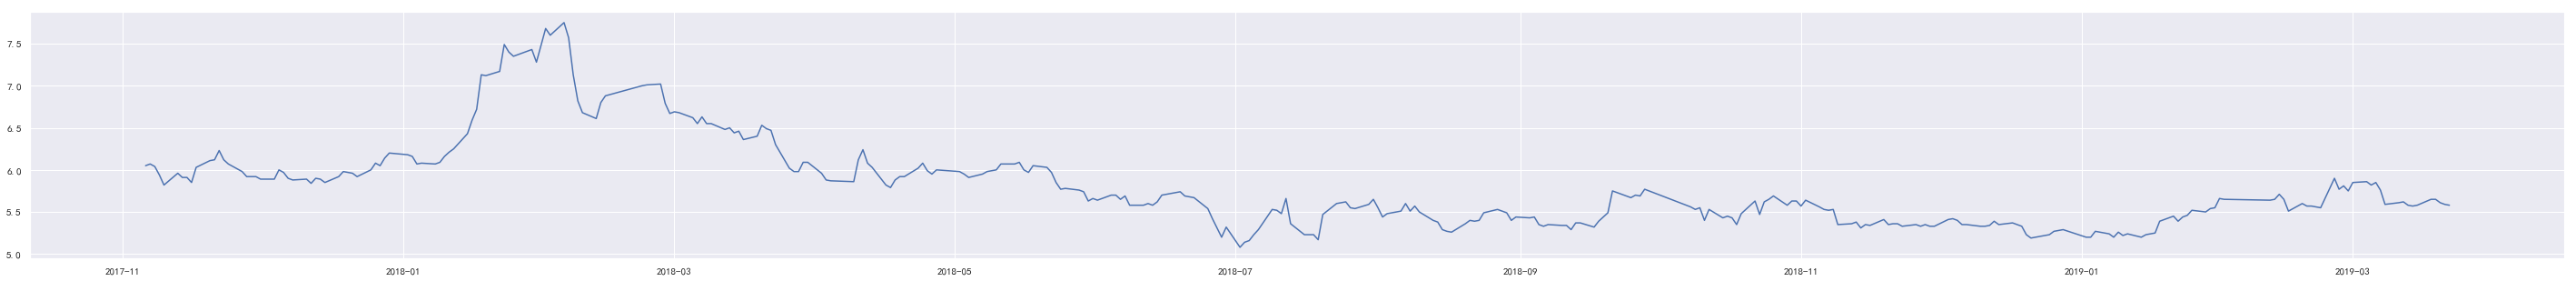

In [7]:
do('601398',train_epochs=10,  window=10, days=3,norm=False,features_appender=fa,top=50,figsize=(50, 5))

#### **acc:0.32508833869607207**

存在過擬合，縮減到5輪。

In [ ]:
do('601398',train_epochs=10,  window=10, days=3,use_slope=False,features_appender=fa_10_2_2,top=-1)

#### acc:0.19572953712791735

In [ ]:
do('601398',train_epochs=10,  window=10, days=5,use_slope=False,features_appender=fa_10_2_2,top=-1)

#### acc:0.07246376811594203

In [ ]:
do('601398',train_epochs=10,  window=10, days=10,use_slope=False,features_appender=fa_10_2_2,top=-1)

### 15

In [ ]:
kwargs={"ADOSC":15,"ATR":15,"NATR":15,"DEMA":15,"EMA":15,"KAMA":15,"MIDPOINT":15,"MIDPRICE":15,"SMA":15,"T3":15,"TEMA":15,"TRIMA":15,"WMA":15}
fa_10_2_2=features_appender_10_2_2(kwargs)

In [ ]:
# do('601398',train_epochs=10,  window=15, days=1,use_slope=False,features_appender=fa_10_2_2,top=-1)

#### acc:0.551971326592148

In [ ]:
do('601398',train_epochs=10,  window=15, days=2,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=15, days=3,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=15, days=5,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=15, days=10,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=15, days=15,use_slope=False,features_appender=fa_10_2_2,top=-1)

### 20

In [ ]:
kwargs={"ADOSC":20,"ATR":20,"NATR":20,"DEMA":20,"EMA":20,"KAMA":20,"MIDPOINT":20,"MIDPRICE":20,"SMA":20,"T3":20,"TEMA":20,"TRIMA":20,"WMA":20}
fa_10_2_2=features_appender_10_2_2(kwargs)

In [ ]:
# do('601398',train_epochs=10,  window=20, days=1,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=20, days=2,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=20, days=3,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=20, days=5,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=20, days=10,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=20, days=15,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=20, days=20,use_slope=False,features_appender=fa_10_2_2,top=-1)

### 30

In [ ]:
kwargs={"ADOSC":30,"ATR":30,"NATR":30,"DEMA":30,"EMA":30,"KAMA":30,"MIDPOINT":30,"MIDPRICE":30,"SMA":30,"T3":30,"TEMA":30,"TRIMA":30,"WMA":30}
fa_10_2_2=features_appender_10_2_2(kwargs)

In [ ]:
# do('601398',train_epochs=10,  window=30, days=1,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=30, days=2,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=30, days=3,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=30, days=5,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=30, days=10,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=30, days=15,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=30, days=20,use_slope=False,features_appender=fa_10_2_2,top=-1)

In [ ]:
do('601398',train_epochs=10,  window=30, days=30,use_slope=False,features_appender=fa_10_2_2,top=-1)